# Filtering and coarse-graining operators

In this notebook, we'll very briefly go over the different filtering and coarse-graining operators we test in the paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyqg
from pyqg.diagnostic_tools import calc_ispec as _calc_ispec
import pyqg_parameterization_benchmarks.coarsening_ops as coarsening

%matplotlib inline
plt.rcParams.update({'font.size': 13})
calc_ispec = lambda *args, **kwargs: _calc_ispec(*args, averaging=False, truncate=False, **kwargs)

## Initialize high-resolution and low-resolution models, run them for a little while

In order to have something to filter and coarse-grain, let's run a model:

In [2]:
m1 = pyqg.QGModel(nx=256, dt=3600., log_level=0)
for _ in range(25000):
    m1._step_forward()

## Initialize our filtering and coarse-graining operators

See our paper for more details on how these are defined; the main point here is that there are many options which lead to qualitatively different results!

In [3]:
op1 = coarsening.Operator1(m1, 64) # spectral truncation + sharp filter
op2 = coarsening.Operator2(m1, 64) # spectral truncation + softer Gaussian filter
op3 = coarsening.Operator3(m1, 64) # GCM-Filters + real-space coarsening
ops = [op1,op2,op3]

INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized


## Visualize effects on $q_1$

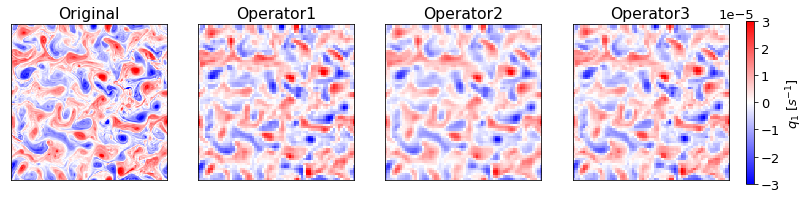

In [4]:
def imshow(arr, vlim=3e-5):
    plt.xticks([]); plt.yticks([])
    return plt.imshow(arr, vmin=-vlim, vmax=vlim, cmap='bwr', interpolation='none')

fig = plt.figure(figsize=(15.5,3))
plt.subplot(1,4,1, title='Original')
imshow(m1.q[0])
for j, op in enumerate(ops):
    plt.subplot(1,4,j+2, title=op.__class__.__name__)
    im = imshow(op.m2.q[0])
fig.colorbar(im, ax=fig.axes, pad=0.02).set_label('$q_1$ [$s^{-1}$]')

It's a bit hard to see the differences in the coarse-grained PV, but let's look at the forcing:

## Visualize effects on $S_{q_1}$

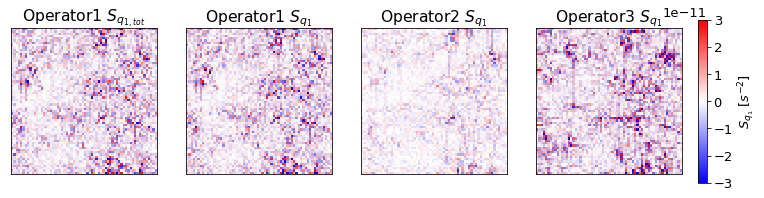

In [5]:
fig = plt.figure(figsize=(14.5,3))
plt.subplot(1,4,1, title='Operator1 $S_{q_{1,tot}}$')
imshow(op1.q_forcing_total[0], 3e-11)
for j, op in enumerate(ops):
    plt.subplot(1,4,j+2, title=op.__class__.__name__ + " $S_{q_1}$")
    im = imshow(op.subgrid_forcing('q')[0], 3e-11)
cb = fig.colorbar(im, ax=fig.axes, pad=0.02).set_label('$S_{q_1}$ [$s^{-2}$]')

Compared to Operator 1 (spectral truncation + sharp filter), we see significantly less forcing with Operator 2 (spectral truncation + Gaussian filter), indicating that advection and coarse-graining are more approximately commutative. With Operator 3 (GCM-Filters + real-space coarsening), we see a bit more forcing.

We can also look at spectra:

Text(0.5, 0, 'Isotropic wavenumber')

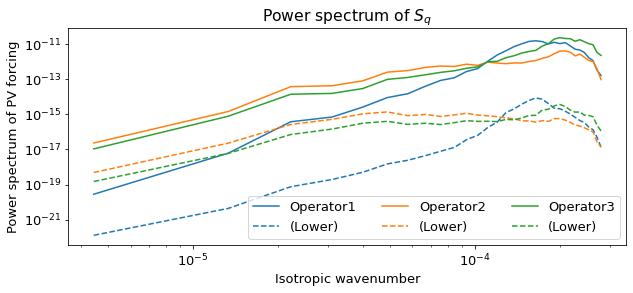

In [40]:
plt.figure(figsize=(10,4))
plt.title("Power spectrum of $S_{q}$")
for j, op in enumerate(ops):
    Sq = op.subgrid_forcing('q')
    line = plt.loglog(*calc_ispec(op.m2, np.abs(m2.fft(Sq))[0]**2), label=op.__class__.__name__)
    plt.loglog(*calc_ispec(op.m2, np.abs(m2.fft(Sq))[1]**2), color=line[0]._color, ls='--', label='(Lower)')
plt.legend(ncol=3)
plt.ylabel("Power spectrum of PV forcing")
plt.xlabel("Isotropic wavenumber")

We can see significant differences between operators and layers. Let's look at similar plots for velocity forcing:

## Visualize effects on $S_{u_1}$

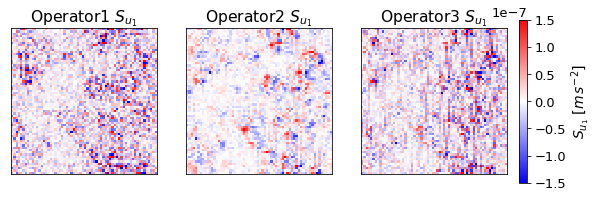

In [6]:
fig = plt.figure(figsize=(14.5,3))
for j, op in enumerate(ops):
    plt.subplot(1,4,j+2, title=op.__class__.__name__ + " $S_{u_1}$")
    im = imshow(op.subgrid_forcing('u')[0], 1.5e-7)
fig.colorbar(im, ax=fig.axes, pad=0.02).set_label('$S_{u_1}$ [$m\,s^{-2}$]', fontsize=14)

Text(0.5, 0, 'Isotropic wavenumber')

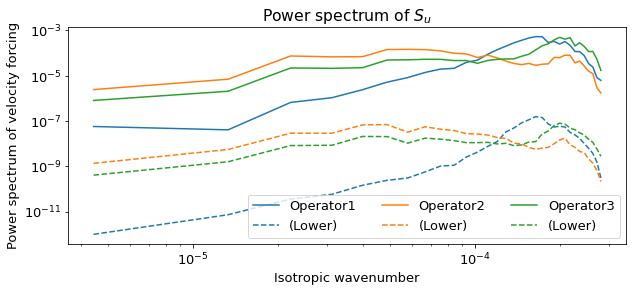

In [39]:
plt.figure(figsize=(10,4))
plt.title("Power spectrum of $S_{u}$")
for j, op in enumerate(ops):
    Su = op.subgrid_forcing('u')
    line = plt.loglog(*calc_ispec(op.m2, np.abs(m2.fft(Su))[0]**2), label=op.__class__.__name__)
    plt.loglog(*calc_ispec(op.m2, np.abs(m2.fft(Su))[1]**2), color=line[0]._color, ls='--', label='(Lower)')
plt.legend(ncol=3)
plt.ylabel("Power spectrum of velocity forcing")
plt.xlabel("Isotropic wavenumber")

We can also compute "subgrid flux" terms, whose divergence is equal to the subgrid forcing (in case we want to train models which obey conservation constraints without needing to enforce that architecturally). Let's look at the $x$-component of the lower-layer subgrid flux, just for fun:

## Visualize effects on $\phi_{q_2}$

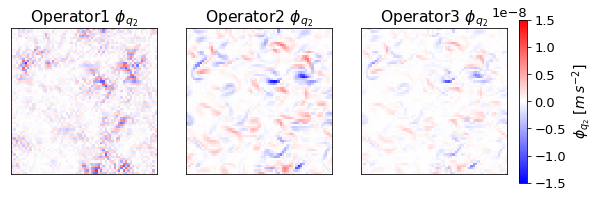

In [7]:
fig = plt.figure(figsize=(14.5,3))
for j, op in enumerate(ops):
    plt.subplot(1,4,j+1, title=op.__class__.__name__ + " $\phi_{q_2}$")
    uq, vq = op.subgrid_fluxes('q')
    im = imshow(uq[1], 1.5e-8)
fig.colorbar(im, ax=fig.axes, pad=0.02).set_label('$\phi_{q_2}$ [$m\,s^{-2}$]', fontsize=14)